<a href="https://colab.research.google.com/github/Pkun-college/Cryptocurrency_predictor_sources/blob/main/Cryptocurrency_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd ~

/root


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Enter the name of the currency whose price is to be predicted:Tether
Enter the amount of epochs:100
Epoch 1/100
23/23 [==============================] - 5s 74ms/step - loss: 0.0140 - val_loss: 3.3691e-05
Epoch 2/100
23/23 [==============================] - 1s 41ms/step - loss: 0.0020 - val_loss: 5.7760e-05
Epoch 3/100
23/23 [==============================] - 1s 42ms/step - loss: 0.0020 - val_loss: 7.0455e-05
Epoch 4/100
23/23 [==============================] - 1s 42ms/step - loss: 0.0017 - val_loss: 1.1877e-04
Epoch 5/100
23/23 [==============================] - 1s 42ms/step - loss: 0.0016 - val_loss: 1.1740e-04
Epoch 6/100
23/23 [==============================] - 1s 43ms/step - loss: 0.0015 - val_loss: 2.3493e-05
Epoch 7/100
23/23 [==============================] - 1s 41ms/step - loss: 0.0014 - val_loss: 1.7688e-05
Epoch 8/100
23/23 [==============================] - 1s 41ms/step - loss: 0.0013 - val_loss: 2.7160e-05
Epoch 9/100
23/23 [==============================] - 1s 42ms/step - 

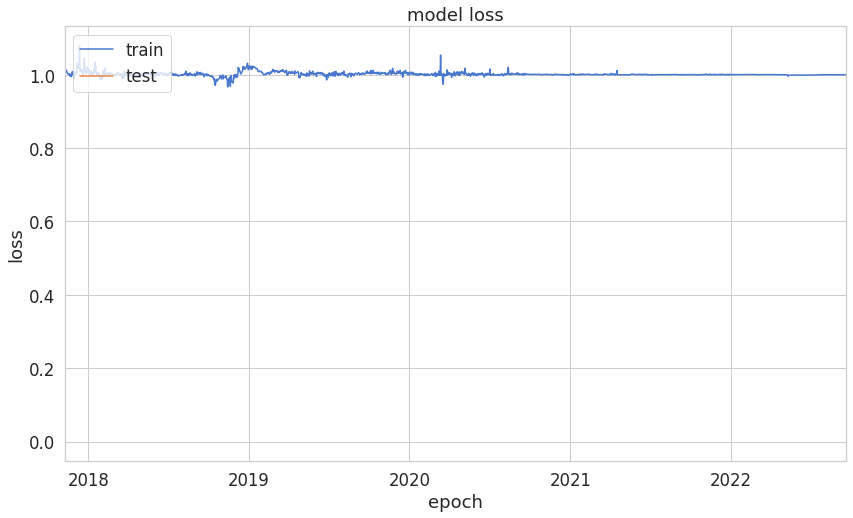

OSError: ignored

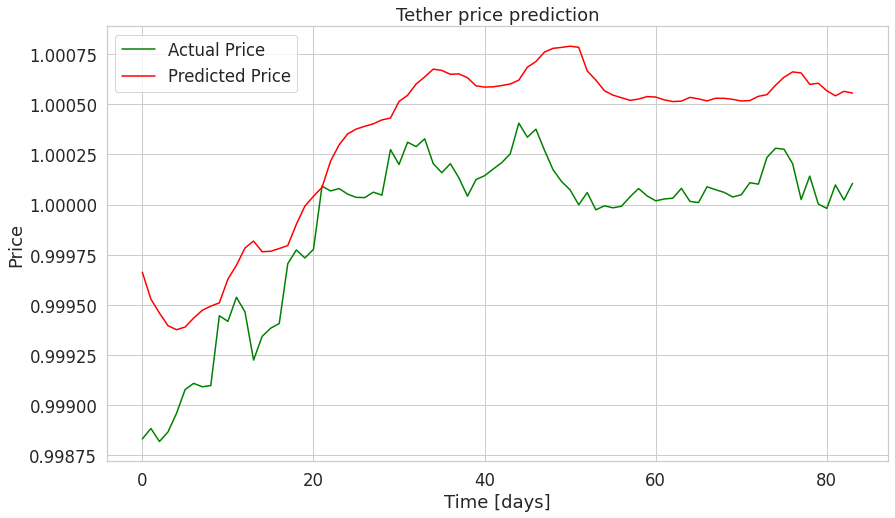

In [ ]:
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from keras.layers import CuDNNLSTM
from keras.models import Sequential
from PIL import Image
from pathlib import Path

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
currency = input("Enter the name of the currency whose price is to be predicted:")
if currency == "Bitcoin":
  csv_path = "https://raw.githubusercontent.com/Pkun-college/Cryptocurrency_predictor_sources/main/BTC-USD%20(1).csv?token=GHSAT0AAAAAABX6BLNHFXIGVTL6NCBZ7OXUYYHE5ZA"
elif currency == "Cardano":
  csv_path = "https://raw.githubusercontent.com/Pkun-college/Cryptocurrency_predictor_sources/main/ADA-USD%20(1).csv"
elif currency == "Binance":
  csv_path = "https://raw.githubusercontent.com/Pkun-college/Cryptocurrency_predictor_sources/main/BNB-USD%20(1).csv"
elif currency == "Dogecoin":
  csv_path = "https://raw.githubusercontent.com/Pkun-college/Cryptocurrency_predictor_sources/main/DOGE-USD%20(1).csv"
elif currency == "Ethereum":
  csv_path = "https://raw.githubusercontent.com/Pkun-college/Cryptocurrency_predictor_sources/main/ETH-USD%20(1).csv"
elif currency == "Polygon":
  csv_path = "https://raw.githubusercontent.com/Pkun-college/Cryptocurrency_predictor_sources/main/MATIC-USD.csv"
elif currency == "Tether":
  csv_path = "https://raw.githubusercontent.com/Pkun-college/Cryptocurrency_predictor_sources/main/USDT-USD%20(1).csv"
else:
  print("Exiting...")
  sys.exit()
df = pd.read_csv(csv_path, parse_dates=['Date'])
df = df.sort_values('Date')
df.head()
df.shape
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)
scaled_close.shape
np.isnan(scaled_close).any()
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)
np.isnan(scaled_close).any()
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)
X_train.shape
X_test.shape
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=int(input("Enter the amount of epochs:")), 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)
model.evaluate(X_test, y_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
if currency == "Bitcoin":
  plt.title('Bitcoin price prediction')
elif currency == "Cardano":
  plt.title('Cardano price prediction')
elif currency == "Dogecoin":
  plt.title('Dogecoin price prediction')
elif currency == "Tether":
  plt.title('Tether price prediction')
elif currency == "Binance":
  plt.title('Binance price prediction')
elif currency == "Polygon":
  plt.title('Polygon price prediction')
elif currency == "Ethereum":
  plt.title('Ethereum price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.savefig('saved_figure.png')
plt.show();